In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem import *
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import random
np.random.seed(7)

In [2]:
tempdata = open("./movie_lines.txt", errors="replace").readlines()

In [3]:
for line in tempdata[:1000]:
    print(line)

L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!

L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!

L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.

L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?

L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.

L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow

L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.

L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No

L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I'm kidding.  You know how sometimes you just become this "persona"?  And you don't know how to quit?

L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?

L868 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ The "real you".

L867 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ What good stuff?

L866 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ I figured you'd get to the good stuff eventually.

L

---
# Preprocessing data

In [4]:
# movie lines (i.e. "They do not!")
x_train_temp = np.array([i.split("+++$+++")[-1].strip() for i in tempdata[:1000]]) # tempdata[:1000]

# character (i.e. "BIANCA")
y_train_temp = [i.split("+++$+++")[-2].strip() for i in tempdata[:1000]] # tempdata[:1000]

In [5]:
print(x_train_temp)

['They do not!' 'They do to!' 'I hope so.' 'She okay?' "Let's go." 'Wow'
 "Okay -- you're gonna need to learn how to lie." 'No'
 'I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?'
 'Like my fear of wearing pastels?' 'The "real you".' 'What good stuff?'
 "I figured you'd get to the good stuff eventually."
 'Thank God!  If I had to hear one more story about your coiffure...'
 "Me.  This endless ...blonde babble. I'm like, boring myself."
 'What crap?' 'do you listen to this crap?' 'No...'
 'Then Guillermo says, "If you go any lighter, you\'re gonna look like an extra on 90210."'
 'You always been this selfish?' 'But' "Then that's all you had to say."
 'Well, no...' "You never wanted to go out with 'me, did you?" 'I was?'
 'I looked for you back at the party, but you always seemed to be "occupied".'
 'Tons' 'Have fun tonight?' 'I believe we share an art instructor'
 'You know Chastity?' 'Looks like things worked out tonight, huh?' 'Hi

In [6]:
print(y_train_temp)

['BIANCA', 'CAMERON', 'BIANCA', 'CAMERON', 'BIANCA', 'CAMERON', 'BIANCA', 'CAMERON', 'BIANCA', 'BIANCA', 'CAMERON', 'BIANCA', 'CAMERON', 'CAMERON', 'BIANCA', 'CAMERON', 'BIANCA', 'CAMERON', 'BIANCA', 'CAMERON', 'BIANCA', 'CAMERON', 'BIANCA', 'CAMERON', 'BIANCA', 'CAMERON', 'BIANCA', 'CAMERON', 'CAMERON', 'BIANCA', 'CAMERON', 'BIANCA', 'BIANCA', 'CAMERON', 'BIANCA', 'CAMERON', 'CAMERON', 'BIANCA', 'CAMERON', 'BIANCA', 'CAMERON', 'BIANCA', 'CAMERON', 'BIANCA', 'CAMERON', 'BIANCA', 'CAMERON', 'CAMERON', 'BIANCA', 'BIANCA', 'CAMERON', 'BIANCA', 'CAMERON', 'BIANCA', 'CAMERON', 'BIANCA', 'CAMERON', 'BIANCA', 'CAMERON', 'CAMERON', 'BIANCA', 'CAMERON', 'BIANCA', 'CAMERON', 'BIANCA', 'CAMERON', 'BIANCA', 'CAMERON', 'BIANCA', 'BIANCA', 'CHASTITY', 'CHASTITY', 'BIANCA', 'CHASTITY', 'BIANCA', 'CHASTITY', 'BIANCA', 'CHASTITY', 'BIANCA', 'BIANCA', 'CHASTITY', 'BIANCA', 'CHASTITY', 'BIANCA', 'BIANCA', 'CHASTITY', 'BIANCA', 'BIANCA', 'JOEY', 'JOEY', 'BIANCA', 'JOEY', 'JOEY', 'BIANCA', 'JOEY', 'BIANCA'

### Getting categories

In [7]:
categories = list(set(y_train_temp))
print(len(categories), "categories:")
print(categories)

30 categories:
['SHARON', 'BOBADILLA', 'MARCHENA', 'BEATRIX', 'SAILOR', 'WALTER', 'MICHAEL', 'PATRICK', 'DAPHNE', 'JORDY', 'MANDELLA', 'ALONSO', 'BIANCA', 'BRUCE', 'MOXICA', 'EMIL', 'UTAPAN', 'FERNANDO', 'MISS PERKY', 'CHASTITY', 'COLUMBUS', 'CAMERON', 'KAT', 'MENDEZ', 'AROJAZ', 'JOEY', 'SANCHEZ', 'PINZON', 'CUTLER', 'ISABEL']


In [8]:
y_train_org = np.array([categories.index(i) for i in y_train_temp])
x_train_org = x_train_temp[:]

num_classes = len(categories)
y_train = []

In [9]:
for n in [categories.index(i) for i in y_train_temp]:
    y_train.append([0 for i in range(num_classes)]) # create an array of 30 zeros
    y_train[-1][n] = 1 # set the index to 1 for the character in mention

In [10]:
for i in range(10):
    print(y_train[i])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Embedding and stemming

In [11]:
all_words = " ".join(x_train_temp).lower().split(" ")
unique_words = list(set(all_words))

stemmer = PorterStemmer()

x_train = []
x_array_size = 6

**Make text into numbers:**
* Takes each line and returns an array of six numbers
* If six or more words, append the appropriate `unique_words` index
* If less than six words, simply add a 0 so the array is always of length 6

Example:
"They do not!" → `[1929, 1261, 1250, 0, 0, 0]`

In [12]:
def make_text_into_numbers(text):
    iwords = text.lower().split(" ")
    numbers = []
    
    for n in iwords:
        try:
            numbers.append(unique_words.index(n))
        except ValueError:
            numbers.append(0)
    
    numbers = numbers + [0, 0, 0, 0, 0] # add zeros in case of less than six words
    return numbers[:x_array_size]

In [13]:
for i in x_train_temp:
    t = make_text_into_numbers(i)
    x_train.append(t)

In [14]:
# Assure that each array in x_train is of length 6
print(set([len(i) for i in x_train]))

{6}


In [15]:
x_train = torch.LongTensor(x_train)
y_train = torch.Tensor(y_train)

In [16]:
print(x_train)
print(y_train)

tensor([[1142, 1520,  839,    0,    0,    0],
        [1142, 1520, 1269,    0,    0,    0],
        [2358, 1144,  944,    0,    0,    0],
        ...,
        [1312, 2498, 2259, 2167, 1052,    0],
        [ 124, 2255, 2178,    0,    0,    0],
        [1520, 1126, 2468,  314,    0,    0]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


---
# Model
### Variant 1

In [17]:
class FirstNet(nn.Module):
    def __init__(self):
        super(FirstNet, self).__init__()
        self.fc1 = nn.Linear(x_array_size, 256)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

### Variant 2

In [18]:
class SecondNet(nn.Module):
    def __init__(self):
        super(SecondNet, self).__init__()
        self.embedding = nn.Embedding(len(unique_words), 128)
        
        self.lstm = nn.LSTM(input_size = 128,
                           hidden_size = 128,
                           num_layers = 1,
                           batch_first = True,
                           bidirectional = False)
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, inp):
        e = self.embedding(inp)
        output, hidden = self.lstm(e)
        
        x = self.fc1(output[:, -1, :])
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [19]:
n = SecondNet()
print("Model", n)
print("Parameters", [param.nelement() for param in n.parameters()])

Model SecondNet(
  (embedding): Embedding(2502, 128)
  (lstm): LSTM(128, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=30, bias=True)
)
Parameters [320256, 65536, 65536, 512, 512, 32768, 256, 7680, 30]


In [20]:
max_words = 6
batch_size = 1
epochs = 5
learning_rate = 0.001

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(n.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

In [22]:
t_loss = []
v_loss = []

t_acc = []
v_acc = []

In [23]:
def avg(l):
    return sum(l) / len(l)

## Train model

In [24]:
n_steps = 300
loss_graph = []

for i in range(n_steps):
    y_pred_train = n(x_train)
    loss_train = loss_fn(y_pred_train, y_train)
    
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    
    loss = loss_train.detach().numpy()
    loss_graph.append(loss)
    
    # Print loss each 25th round
    if i%25 == 0:
        print(loss)

0.2528883
0.25278845
0.25268865
0.2525889
0.25248918
0.25238952
0.25228992
0.25219035
0.25209093
0.25199142
0.25189203
0.25179267


### Plot loss

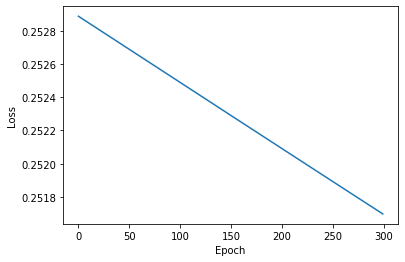

In [25]:
x_values = [i for i in range(n_steps)]

plt.plot(x_values, loss_graph)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Test model
* From the human input, the model finds the character most likely to say this
* Returns a random line from the same character
* Stops the interaction when the user inputs **"Stop"**

In [26]:
def classify(line):
    indices = make_text_into_numbers(line)
    tensor = torch.LongTensor([indices])
    output = n(tensor).detach().numpy()
    character_index = np.argmax(output)
    return character_index

In [27]:
# Get a random line from the same character
def get_random_text_from_index(char_index):
    res = -1
    while res != char_index:
        aNumber = random.randint(0, len(y_train_org) - 1)
        res = y_train_org[aNumber]
    return x_train_org[aNumber]

In [28]:
human_name = input("Oh na na, what's your name? ").upper()

Oh na na, what's your name? Cristina


In [29]:
print("READY")
print("-" * 5)
print()

human_input = " "
while human_input != "Stop":
    character_index = classify(human_input)
    text = get_random_text_from_index(character_index)
    print(f"{categories[character_index]}: {text}")
    human_input = input(f"{human_name}: ")

print()
print("-" * 5)
print("THE END")

READY
-----

BRUCE: Just sent 'em through.
CRISTINA: Okay, let's go
BRUCE: Didn't have you pegged for a Gigglepuss fan.  Aren't they a little too pre-teen belly-button ring for you?
CRISTINA: No I love them
BRUCE: Never
CRISTINA: Always
BRUCE: Didn't have you pegged for a Gigglepuss fan.  Aren't they a little too pre-teen belly-button ring for you?
CRISTINA: Let's go to the prom
BRUCE: Didn't have you pegged for a Gigglepuss fan.  Aren't they a little too pre-teen belly-button ring for you?
CRISTINA: Where is the money?
BEATRIX: I'm not asking you to swear to anything.
CRISTINA: Yes you are
BRUCE: Just sent 'em through.
CRISTINA: Go away Bruce
BRUCE: Never
CRISTINA: Yes
BRUCE: Just sent 'em through.
CRISTINA: Where is the money?
BEATRIX: They tried... but I didn't let them.
CRISTINA: Good
BRUCE: Just sent 'em through.
CRISTINA: Stop

-----
THE END
